In [1]:
import pandas as pd
import numpy as np
import string, re, math

#Imports for plotting
import seaborn as sns
import matplotlib.pyplot as plt

#options
pd.options.display.max_rows = 50
import warnings
warnings.filterwarnings('ignore')

In [2]:
import plotly.express as px

## Cleaning CSV Files

**Read in Data**

In [3]:
df1 = pd.read_csv('data/glassdoor_ratings1_62.csv')
df2 = pd.read_csv('data/glassdoor_ratings2_37.csv')
df3 = pd.read_csv('data/glassdoor_ratings3_199.csv')
df4 = pd.read_csv('data/glassdoor_ratings5_797.csv')
df5 = pd.read_csv('data/glassdoor_ratings6_846.csv')
df6 = pd.read_csv('data/glassdoor_ratings7_453.csv')  
df7 = pd.read_csv('data/glassdoor_ratings8_873.csv') #scrape # 8
df8 = pd.read_csv('data/glassdoor_ratings_1to50.csv')
df9 = pd.read_csv('data/glassdoor_ratings_51to200.csv')

#Combine data frames
data = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9])

print('Length of data set: ',len(data))
print('Number of duplicates: ', data['NAME'].duplicated().sum())

Length of data set:  4327
Number of duplicates:  1404


In [4]:
data.head()

,NAME,SIZE,LOCATION_HQ,INDUSTRY,RATING_OVERALL,RATING_DI,RATING_CV,RATING_WL,RATING_SM,RATING_CB,RATING_CO,NUM_REVIEWS,DESCRIPTION,MISSION
0,Google,10000+ Employees,"Mountain View, CA",Internet,4.5,4.4,4.4,4.3,4.1,4.5,4.3,"See All 18,362 Reviews",NaN,NaN
1,Microsoft,10000+ Employees,"Redmond, WA",Computer Hardware & Software,4.4,4.4,4.3,4.1,4.0,4.1,4.1,"See All 29,389 Reviews",Our drive to change the world unites us!\n\nMi...,NaN
2,Apple,10000+ Employees,"Cupertino, CA",Computer Hardware & Software,4.3,4.4,4.3,3.7,3.7,4.3,3.8,"See All 20,851 Reviews",We’re a diverse collective of thinkers and doe...,NaN
3,US Air Force,10000+ Employees,"Washington, DC",Federal Agencies,4.2,4.2,4.0,3.3,3.4,4.3,4.2,"See All 16,600 Reviews",The mission of the US Department of the Air Fo...,NaN
4,Cisco Systems,10000+ Employees,"San Jose, CA",Computer Hardware & Software,4.2,4.3,4.3,4.2,3.8,4.1,3.9,"See All 21,804 Reviews","#WeAreCisco, where each person is unique, but ...",Mission: Cisco wants you to bring your uniquen...


### Preliminary Cleaning
 - Handle null values
 - reset indices 
 - drop duplicates

In [5]:
#Reset index to see all rows
data.reset_index(inplace=True)

In [6]:
# #change '  ' to null values
# data['FULL_DESCRIPTION'] = data['FULL_DESCRIPTION'].mask(data['FULL_DESCRIPTION']== '  ')

In [7]:
###Inspect companies with nan description?


In [8]:
#Drop null values from RATING_DI
print('NaN values dropped from RATING_DI: ', data.RATING_DI.isna().sum())
data.dropna(subset=['RATING_DI'], inplace=True)

#Drop null values from DESCRIPTION
print('NaN values dropped from DESCRIPTION: ', data.DESCRIPTION.isna().sum())
data.dropna(subset=['DESCRIPTION'], inplace=True)

NaN values dropped from RATING_DI:  477
NaN values dropped from DESCRIPTION:  139


In [9]:
#Drop duplicate companies by 'NAME' - drops size from 1941 to 1188
print('Duplicates dropped: ', data['NAME'].duplicated().sum())
data.drop_duplicates(subset='NAME', keep='last', inplace=True)
data = data.drop(['index'], axis=1)

Duplicates dropped:  1180


In [10]:
### RESET INDEX HERE TO NAME ### (easier searching?)
data = data.set_index('NAME')

In [11]:
# #reset index to begin at 0
# ###data.reset_index(inplace=True)

# #drop extra indices
# # data = data.drop(['index', 'level_0'], axis=1)
# data = data.drop(['index'], axis=1)


In [12]:
#Check out dataframe
print('Shape: ', data.shape)
data.head(3)

Shape:  (2531, 13)


,SIZE,LOCATION_HQ,INDUSTRY,RATING_OVERALL,RATING_DI,RATING_CV,RATING_WL,RATING_SM,RATING_CB,RATING_CO,NUM_REVIEWS,DESCRIPTION,MISSION
NAME,,,,,,,,,,,,,
McKinsey & Company,10000+ Employees,"New York, NY",Consulting,4.5,4.4,4.4,3.0,4.1,4.4,4.5,"See All 5,198 Reviews",We work with leaders across sectors to tackle ...,Mission: Our mission is two-fold: to help our ...
Cornell University,10000+ Employees,"Ithaca, NY",Colleges & Universities,4.5,4.3,4.4,4.0,4.1,4.1,4.2,"See All 1,765 Reviews","Cornell is a private, Ivy League university re...",NaN
UC Santa Barbara,5001 to 10000 Employees,"Santa Barbara, CA",Colleges & Universities,4.5,4.2,4.3,4.4,4.1,3.7,4.0,"See All 1,049 Reviews","Dude, let's hit the beach! And then we'll hit ...",NaN


## Feature Engineering
 - Initial cleaning of DESCRIPTION
 - Prepare continuous variables: NUM_REVIEWS, RATING_DI
 - New features: HQ_STATE, defining TARGET variable

### New features based on DECRIPTION

In [13]:
# change null values in MISSION and DESCRIPTION to ' '
data['MISSION'].fillna(' ', inplace=True)
data['DESCRIPTION'].fillna(' ', inplace=True)

#New column 'FULL_DESCRIPTION'
data['FULL_DESCRIPTION'] = np.add(data['DESCRIPTION'], data['MISSION'])

In [14]:
# New column for length of description
data['DESC_LEN'] = data['FULL_DESCRIPTION'].apply(lambda x: len(x))

In [15]:
### BONUS ###
# how to add a space before "Mission:"??

### Clean up NUM_REVIEWS column
- return numbers only

In [16]:
def get_digits(s):
    #remove commas
    exclude = set(string.punctuation)
    s = ''.join(num for num in s if num not in exclude)

    #return digits only
    return s.split()[2]

#apply function to NUM_REVIEWS and change datatype to int
data['NUM_REVIEWS'] = data['NUM_REVIEWS'].apply(get_digits).astype(int)

In [17]:
#removing companies with too few reviews ### try changing this threshold to 50?
print('Number of companies dropped:', (data['NUM_REVIEWS'] < 100).sum())
data = data[(data['NUM_REVIEWS'] > 100)]

Number of companies dropped: 305


### New feature based on RATING_DI

**drop lower than xx reviews**

The rating scale used by Glassdoor.com is a scale from 1 to 5. Therefore, we will establish our **Target variable at 4.0**, since that would indicate an "A" rating on this scale.

In [18]:
#Checking out stats for rating columns
data.describe()

,RATING_OVERALL,RATING_DI,RATING_CV,RATING_WL,RATING_SM,RATING_CB,RATING_CO,NUM_REVIEWS,DESC_LEN
count,2225.000000,2225.000000,2225.000000,2225.000000,2225.000000,2225.000000,2225.000000,2225.000000,2225.000000
mean,3.876494,3.963326,3.799775,3.683371,3.461798,3.648449,3.581618,1334.895730,857.261124
std,0.358956,0.527221,0.430330,0.429407,0.447381,0.458472,0.425755,4103.038674,407.438617
min,1.900000,1.000000,1.700000,1.500000,1.600000,1.900000,1.900000,101.000000,44.000000
25%,3.700000,3.700000,3.600000,3.400000,3.200000,3.400000,3.300000,211.000000,632.000000
50%,3.900000,4.000000,3.800000,3.700000,3.400000,3.700000,3.600000,412.000000,758.000000
75%,4.100000,4.300000,4.100000,4.000000,3.700000,3.900000,3.800000,1111.000000,1001.000000
max,5.000000,5.000000,5.000000,4.900000,4.900000,4.900000,4.900000,74692.000000,4883.000000


In [19]:
# Checking average Diversity and Inclusion score
data.RATING_DI.mean()

3.963325842696629

In [20]:
data.RATING_OVERALL.mean()

3.8764943820224724

In [21]:
#how many companies are above and below the threshold?
print('Percentage of companpies below threshold:', 
      (len(data[(data['RATING_DI'] <= 4.0)]) / (len(data)))*100)
print('Percentage of companpies above threshold:', 
      (len(data[(data['RATING_DI'] > 4.0)]) / (len(data)))*100)

Percentage of companpies below threshold: 54.067415730337075
Percentage of companpies above threshold: 45.932584269662925


In [22]:
#RATING_DI_BIN
#removing decimal value for data visualization
def truncate(f):
    return math.floor(f * 10 ** 0) / 10 ** 0

data['RATING_DI_BIN'] = data['RATING_DI'].apply(truncate).astype(int)

In [23]:
data.head(3)

,SIZE,LOCATION_HQ,INDUSTRY,RATING_OVERALL,RATING_DI,RATING_CV,RATING_WL,RATING_SM,RATING_CB,RATING_CO,NUM_REVIEWS,DESCRIPTION,MISSION,FULL_DESCRIPTION,DESC_LEN,RATING_DI_BIN
NAME,,,,,,,,,,,,,,,,
McKinsey & Company,10000+ Employees,"New York, NY",Consulting,4.5,4.4,4.4,3.0,4.1,4.4,4.5,5198,We work with leaders across sectors to tackle ...,Mission: Our mission is two-fold: to help our ...,We work with leaders across sectors to tackle ...,1383,4
Cornell University,10000+ Employees,"Ithaca, NY",Colleges & Universities,4.5,4.3,4.4,4.0,4.1,4.1,4.2,1765,"Cornell is a private, Ivy League university re...",,"Cornell is a private, Ivy League university re...",618,4
UC Santa Barbara,5001 to 10000 Employees,"Santa Barbara, CA",Colleges & Universities,4.5,4.2,4.3,4.4,4.1,3.7,4.0,1049,"Dude, let's hit the beach! And then we'll hit ...",,"Dude, let's hit the beach! And then we'll hit ...",654,4


### New feature based on SIZE

In [24]:
# ## Assigning continuous variable to SIZE column

# conditions = [ 
#     data['SIZE'] == '10000+ Employees',
#     data['SIZE'] == '5001 to 10000 Employees',
#     data['SIZE'] == '1001 to 5000 Employees', 
#     data['SIZE'] == '501 to 1000 Employees',
#     ((data['SIZE'] == '201 to 500 Employees')| (data['SIZE'] == '51 to 200 Employees'))] 

# ## list of choices to be returned if said condition is True
# choices = [
#     5, #10k+
#     4, #5001 to 10k Employees
#     3, #1001 to 5k Employees 
#     2, #500 to 1k
#     1] #fewer than 500 Employees

# data['SIZE_BIN'] = np.select(conditions, choices, default=None)

# #Convert to float
# data['SIZE_BIN'] = data['SIZE_BIN'].astype(float)

In [25]:
## Assigning continuous variable to SIZE column

conditions = [ 
    data['SIZE'] == '10000+ Employees',
    data['SIZE'] == '5001 to 10000 Employees',
    data['SIZE'] == '1001 to 5000 Employees', 
    ((data['SIZE'] == '501 to 1000 Employees')|(data['SIZE'] == '201 to 500 Employees')| (data['SIZE'] == '51 to 200 Employees'))] 

## list of choices to be returned if said condition is True
choices = [
    4, #10k+
    3, #5001 to 10k Employees
    2, #1001 to 5k Employees 
    1] #fewer than 1k Employees

data['SIZE_BIN'] = np.select(conditions, choices, default=None)

#Convert to float
data['SIZE_BIN'] = data['SIZE_BIN'].astype(float)

In [26]:
data.SIZE_BIN.value_counts(normalize=True, sort=False)

4.0    0.335493
3.0    0.164276
2.0    0.392411
1.0    0.107820
Name: SIZE_BIN, dtype: float64

### New feature based on LOCATION_HQ

In [27]:
data['HQ_STATE'] = data['LOCATION_HQ'].apply(lambda x: x[-2:])

### Defining TARGET variable

In [28]:
# New column for Target variable - companies with Diversity and Inclusion Rating over 4.0
data['TARGET'] = np.where(data['RATING_DI'] >= 4.0 , 1, 0)

Text(0.5, 1.0, 'Distribution of Class')

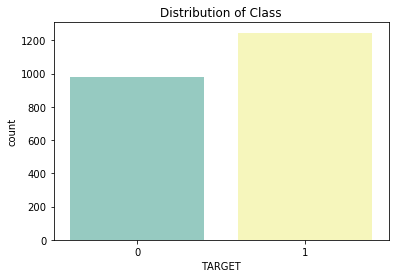

In [29]:
# Checking for class imbalance
sns.countplot(data['TARGET'], palette='Set3').set_title('Distribution of Class')

## EDA on data
**Plots:**
 - scatterplots: DI rating OR target vs 
     - of reviews
     - industry
     - state
     - company size
 - bar plots 
     - industry
     - state
     - size
 
**Additional Notes:**
 - continuous variables: SIZE_BIN, rating columns, NUM_REVIEWS
 - are companies who have more lengthy descriptions more inclusive?

### Inspecting distribution and overall trends

In [30]:
##inspect size column
data.SIZE.value_counts()

1001 to 5000 Employees     848
10000+ Employees           725
5001 to 10000 Employees    355
51 to 200 Employees        220
1 to 50 Employees           57
201 to 500 Employees         8
Unknown                      7
501 to 1000 Employees        5
Name: SIZE, dtype: int64

In [31]:
data.SIZE_BIN.value_counts(normalize=True, sort=False)
#5: 10k+
#4: 5k-10k
#3: 1k-5k
#2: 500-1k, Under 500
#1: Under 500

# 5.0    0.369792
# 4.0    0.184896
# 3.0    0.441667
# 1.0    0.001042
# 2.0    0.002604

4.0    0.335493
3.0    0.164276
2.0    0.392411
1.0    0.107820
Name: SIZE_BIN, dtype: float64

In [32]:
#Most common industries
data.INDUSTRY.value_counts()[:10].to_frame()

,INDUSTRY
Health Care Services & Hospitals,216
Colleges & Universities,161
Computer Hardware & Software,90
IT Services,74
Staffing & Outsourcing,70
Enterprise Software & Network Solutions,67
Advertising & Marketing,66
Insurance Carriers,62
Investment Banking & Asset Management,58
Consumer Products Manufacturing,56


In [33]:
data.head(3)

,SIZE,LOCATION_HQ,INDUSTRY,RATING_OVERALL,RATING_DI,RATING_CV,RATING_WL,RATING_SM,RATING_CB,RATING_CO,NUM_REVIEWS,DESCRIPTION,MISSION,FULL_DESCRIPTION,DESC_LEN,RATING_DI_BIN,SIZE_BIN,HQ_STATE,TARGET
NAME,,,,,,,,,,,,,,,,,,,
McKinsey & Company,10000+ Employees,"New York, NY",Consulting,4.5,4.4,4.4,3.0,4.1,4.4,4.5,5198,We work with leaders across sectors to tackle ...,Mission: Our mission is two-fold: to help our ...,We work with leaders across sectors to tackle ...,1383,4,4.0,NY,1
Cornell University,10000+ Employees,"Ithaca, NY",Colleges & Universities,4.5,4.3,4.4,4.0,4.1,4.1,4.2,1765,"Cornell is a private, Ivy League university re...",,"Cornell is a private, Ivy League university re...",618,4,4.0,NY,1
UC Santa Barbara,5001 to 10000 Employees,"Santa Barbara, CA",Colleges & Universities,4.5,4.2,4.3,4.4,4.1,3.7,4.0,1049,"Dude, let's hit the beach! And then we'll hit ...",,"Dude, let's hit the beach! And then we'll hit ...",654,4,3.0,CA,1


In [34]:
#Checking datatypes for plotting
print(data.info()) #Sanity Check

<class 'pandas.core.frame.DataFrame'>
Index: 2225 entries, McKinsey & Company to eAssist
Data columns (total 19 columns):
SIZE                2225 non-null object
LOCATION_HQ         2225 non-null object
INDUSTRY            2225 non-null object
RATING_OVERALL      2225 non-null float64
RATING_DI           2225 non-null float64
RATING_CV           2225 non-null float64
RATING_WL           2225 non-null float64
RATING_SM           2225 non-null float64
RATING_CB           2225 non-null float64
RATING_CO           2225 non-null float64
NUM_REVIEWS         2225 non-null int64
DESCRIPTION         2225 non-null object
MISSION             2225 non-null object
FULL_DESCRIPTION    2225 non-null object
DESC_LEN            2225 non-null int64
RATING_DI_BIN       2225 non-null int64
SIZE_BIN            2161 non-null float64
HQ_STATE            2225 non-null object
TARGET              2225 non-null int64
dtypes: float64(8), int64(4), object(7)
memory usage: 427.7+ KB
None


In [35]:
# import seaborn as sns
# import matplotlib.pyplot as plt

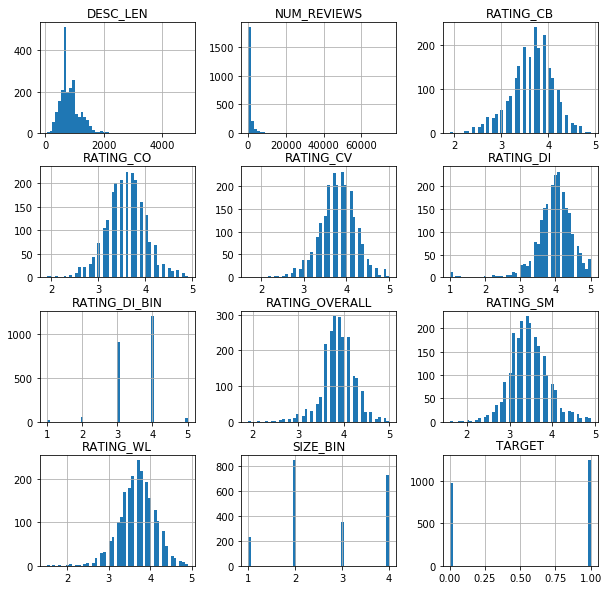

In [36]:
data.hist(bins=50, figsize=(10,10)) #sharex, sharey
plt.show()

Rating distributions are mostly normal

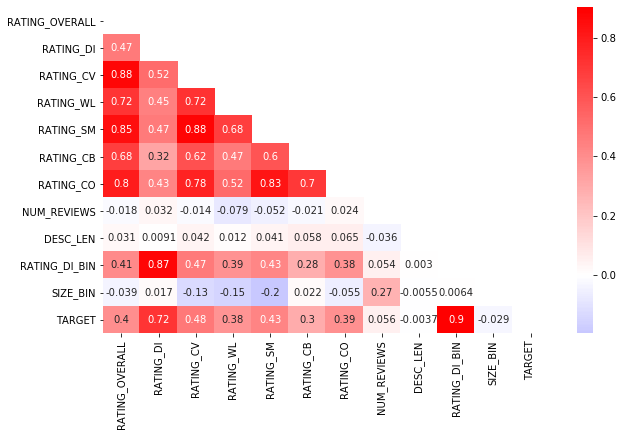

In [37]:
# Looking for any hidden correlations between continuous variables

fig, ax = plt.subplots(figsize=(10, 6))

corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, cmap='bwr', center=0, annot=True)

# fix for matplotlib bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

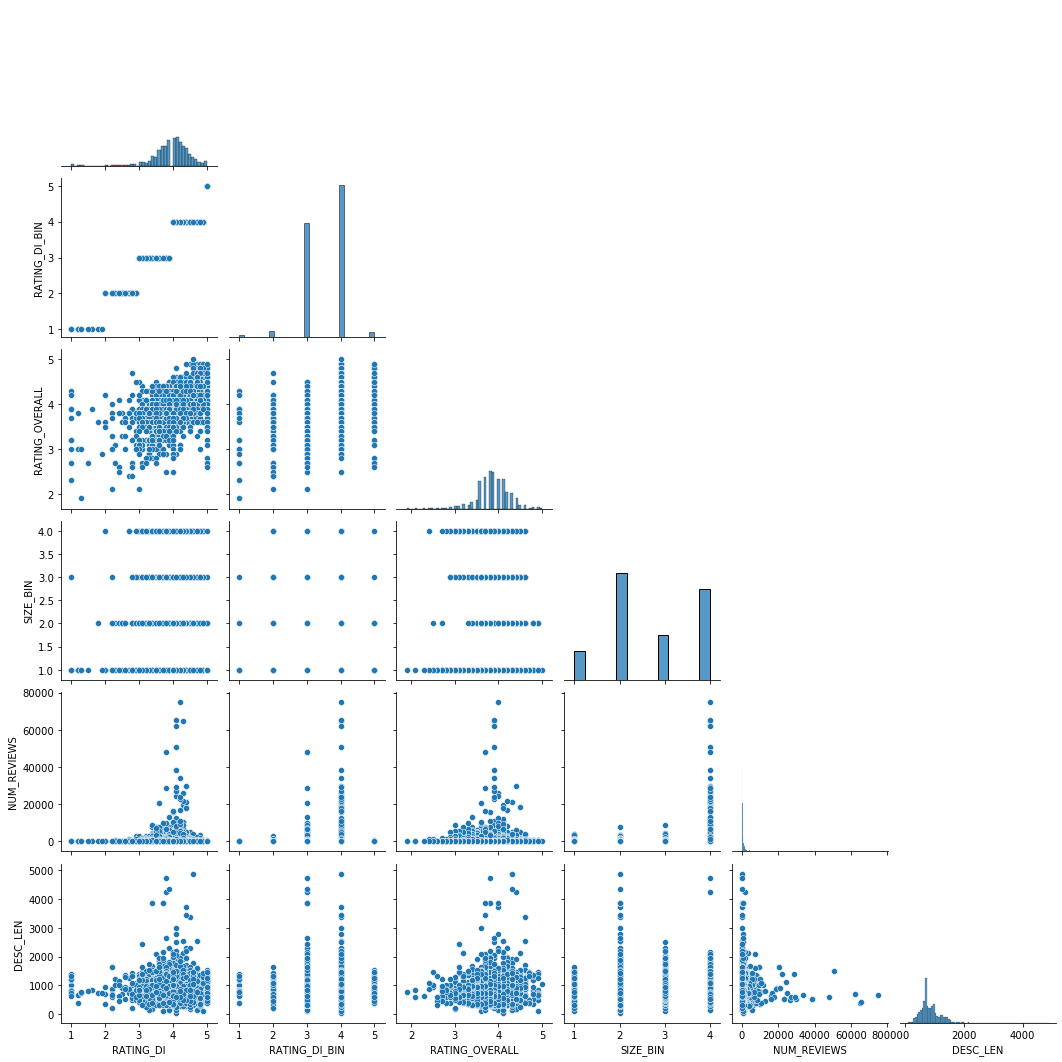

In [38]:
###find a better plot for this (bubbles?)
#continuous variables
sns.pairplot(data[['RATING_DI', 'RATING_DI_BIN', 'RATING_OVERALL', 'SIZE_BIN', 'SIZE', 'NUM_REVIEWS', 'DESC_LEN']], corner=True)


In [39]:
data.head(3)

,SIZE,LOCATION_HQ,INDUSTRY,RATING_OVERALL,RATING_DI,RATING_CV,RATING_WL,RATING_SM,RATING_CB,RATING_CO,NUM_REVIEWS,DESCRIPTION,MISSION,FULL_DESCRIPTION,DESC_LEN,RATING_DI_BIN,SIZE_BIN,HQ_STATE,TARGET
NAME,,,,,,,,,,,,,,,,,,,
McKinsey & Company,10000+ Employees,"New York, NY",Consulting,4.5,4.4,4.4,3.0,4.1,4.4,4.5,5198,We work with leaders across sectors to tackle ...,Mission: Our mission is two-fold: to help our ...,We work with leaders across sectors to tackle ...,1383,4,4.0,NY,1
Cornell University,10000+ Employees,"Ithaca, NY",Colleges & Universities,4.5,4.3,4.4,4.0,4.1,4.1,4.2,1765,"Cornell is a private, Ivy League university re...",,"Cornell is a private, Ivy League university re...",618,4,4.0,NY,1
UC Santa Barbara,5001 to 10000 Employees,"Santa Barbara, CA",Colleges & Universities,4.5,4.2,4.3,4.4,4.1,3.7,4.0,1049,"Dude, let's hit the beach! And then we'll hit ...",,"Dude, let's hit the beach! And then we'll hit ...",654,4,3.0,CA,1


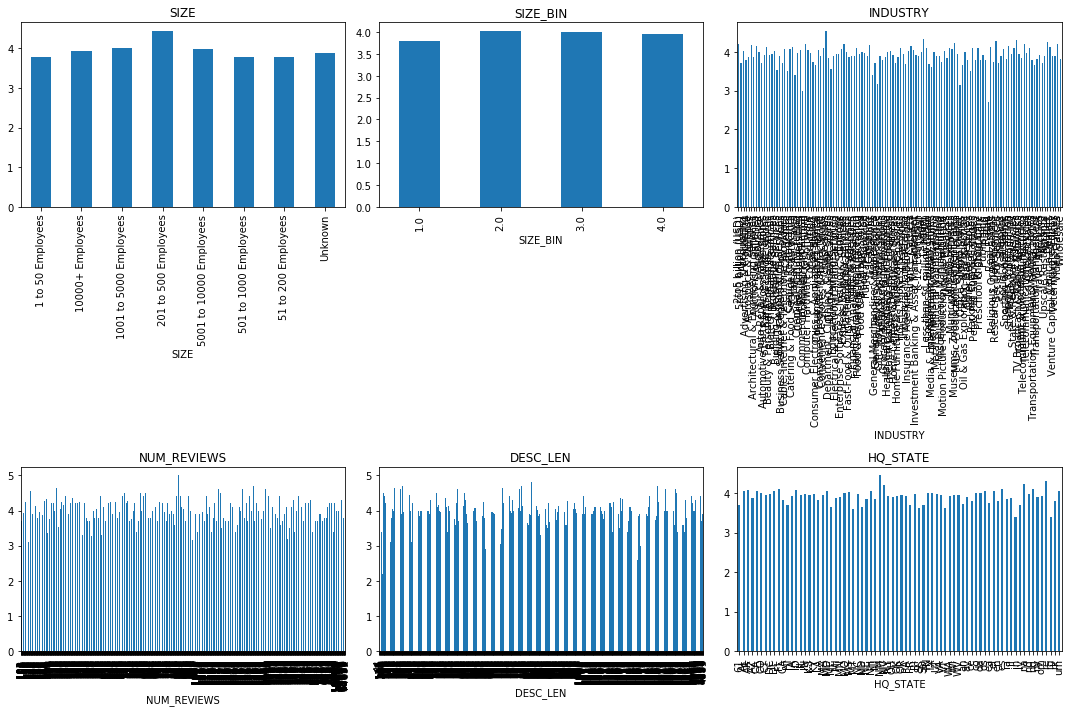

In [40]:
# Bar plots of categorical data
#zipcode explored later
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

categoricals = ['SIZE', 'SIZE_BIN', 'INDUSTRY', 'NUM_REVIEWS', 'DESC_LEN', 'HQ_STATE']

for col, ax in zip(categoricals, axes.flatten()):
    (data.groupby(col)               # group values together by column of interest
         .mean()['RATING_DI']        # take the mean of the saleprice for each group
         .plot
         .bar(ax=ax))                # create a bar graph on the ax    
    ax.set_title(col)                # Make the title the name of the column
fig.tight_layout()

### Exploring Target Variable: Rating

In [41]:
data.SIZE.value_counts()

1001 to 5000 Employees     848
10000+ Employees           725
5001 to 10000 Employees    355
51 to 200 Employees        220
1 to 50 Employees           57
201 to 500 Employees         8
Unknown                      7
501 to 1000 Employees        5
Name: SIZE, dtype: int64

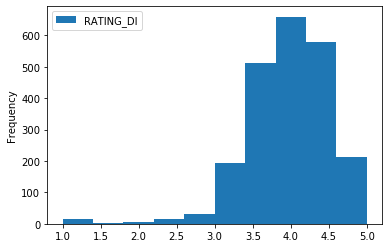

In [42]:
#Distribution of ratings
data.plot(kind='hist', 
          x='SIZE_BIN', 
          y='RATING_DI')
plt.show()

Text(0.5, 0, 'Company Size')

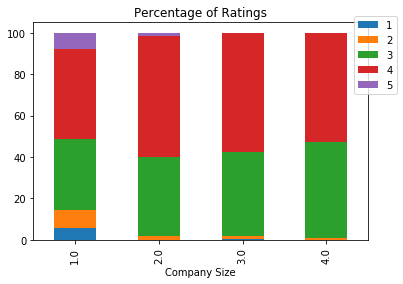

In [43]:
# Percentages (normalize = True)
x = data.groupby('SIZE_BIN')['RATING_DI_BIN'].value_counts(normalize=True).unstack() * 100

fig,ax = plt.subplots()
x.plot.bar(stacked=True,ax=ax,)

ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Percentage of Ratings')
plt.xlabel('Company Size')

Text(0.5, 0, 'Company Size')

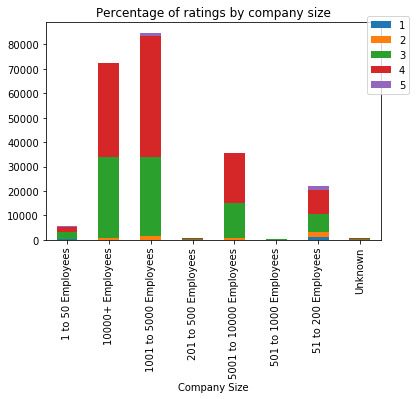

In [44]:
# Percentages (normalize = True)
x = data.groupby('SIZE')['RATING_DI_BIN'].value_counts().unstack() * 100

fig,ax = plt.subplots()
x.plot.bar(stacked=True,ax=ax,)

ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Percentage of ratings by company size')
plt.xlabel('Company Size')

In [45]:
##Size vs Rating DI
data.groupby('SIZE')['RATING_DI_BIN'].value_counts(normalize=True, sort=False).to_frame()#[:50]

RATING_DI_BIN
SIZE                    RATING_DI_BIN               
1 to 50 Employees       1                   0.052632
                        2                   0.035088
                        3                   0.473684
                        4                   0.368421
                        5                   0.070175
10000+ Employees        2                   0.009655
                        3                   0.460690
                        4                   0.528276
                        5                   0.001379
1001 to 5000 Employees  1                   0.001179
                        2                   0.018868
                        3                   0.380896
                        4                   0.581368
                        5                   0.017689
201 to 500 Employees    3                   0.250000
                        4                   0.625000
                        5                   0.125000
5001 to 10000 Employees 1                   0.002817
                        2                   0.014085
                        3                   0.408451
                        4                   0.571831
                        5                   0.002817
501 to 1000 Employees   3                   0.800000
                        4                   0.200000
51 to 200 Employees     1                   0.059091
                        2                   0.090909
                        3                   0.336364
                        4                   0.436364
                        5                   0.077273
Unknown                 1                   0.142857
                        3                   0.142857
                        4                   0.571429
                        5                   0.142857

### Inspecting INDUSTRY

In [46]:
print('Number of industries: ', len(data.INDUSTRY.unique())) #126

# Uncomment below line to see all industries
#list(data.INDUSTRY.unique())


Number of industries:  126


In [47]:
# Top 50 with value counts
data.INDUSTRY.value_counts()[:50].to_frame()

,INDUSTRY
Health Care Services & Hospitals,216
Colleges & Universities,161
Computer Hardware & Software,90
IT Services,74
Staffing & Outsourcing,70
Enterprise Software & Network Solutions,67
Advertising & Marketing,66
Insurance Carriers,62
Investment Banking & Asset Management,58
Consumer Products Manufacturing,56


In [48]:
# Uncomment below line to see bottom 50 industries with value counts
#data.INDUSTRY.value_counts(ascending=True)[:50].to_frame()

## Saving final CSV

In [49]:
data.head(3) #Sanity Check

,SIZE,LOCATION_HQ,INDUSTRY,RATING_OVERALL,RATING_DI,RATING_CV,RATING_WL,RATING_SM,RATING_CB,RATING_CO,NUM_REVIEWS,DESCRIPTION,MISSION,FULL_DESCRIPTION,DESC_LEN,RATING_DI_BIN,SIZE_BIN,HQ_STATE,TARGET
NAME,,,,,,,,,,,,,,,,,,,
McKinsey & Company,10000+ Employees,"New York, NY",Consulting,4.5,4.4,4.4,3.0,4.1,4.4,4.5,5198,We work with leaders across sectors to tackle ...,Mission: Our mission is two-fold: to help our ...,We work with leaders across sectors to tackle ...,1383,4,4.0,NY,1
Cornell University,10000+ Employees,"Ithaca, NY",Colleges & Universities,4.5,4.3,4.4,4.0,4.1,4.1,4.2,1765,"Cornell is a private, Ivy League university re...",,"Cornell is a private, Ivy League university re...",618,4,4.0,NY,1
UC Santa Barbara,5001 to 10000 Employees,"Santa Barbara, CA",Colleges & Universities,4.5,4.2,4.3,4.4,4.1,3.7,4.0,1049,"Dude, let's hit the beach! And then we'll hit ...",,"Dude, let's hit the beach! And then we'll hit ...",654,4,3.0,CA,1


**Save updated CSV including all features**

In [50]:
data.to_csv('data/glassdoor_ratings_main.csv', index=False)

## Do we need any of the below cells?

**Create and save DTM (document term matrix)**

In [51]:
# ##This cell creates DF of only clean description and company name - same thing as data.CLEAN_DESCRIPTION
# ## UNNECESSARY STEP?


# # Creating a new df of only CLEAN_DESCRIPTION
# df_clean_description = data[['CLEAN_DESCRIPTION']]

# # Take a look
# df_clean_description.head()

In [52]:
# #saving for NLP EDA -- DO I NEED THIS??
# df_clean_description.to_csv('data/df_clean_description.csv', index=False)

## EDA on NLP - keep in this notebook? transfer over?
Using data term matrix

In [53]:
data.head(3)

,SIZE,LOCATION_HQ,INDUSTRY,RATING_OVERALL,RATING_DI,RATING_CV,RATING_WL,RATING_SM,RATING_CB,RATING_CO,NUM_REVIEWS,DESCRIPTION,MISSION,FULL_DESCRIPTION,DESC_LEN,RATING_DI_BIN,SIZE_BIN,HQ_STATE,TARGET
NAME,,,,,,,,,,,,,,,,,,,
McKinsey & Company,10000+ Employees,"New York, NY",Consulting,4.5,4.4,4.4,3.0,4.1,4.4,4.5,5198,We work with leaders across sectors to tackle ...,Mission: Our mission is two-fold: to help our ...,We work with leaders across sectors to tackle ...,1383,4,4.0,NY,1
Cornell University,10000+ Employees,"Ithaca, NY",Colleges & Universities,4.5,4.3,4.4,4.0,4.1,4.1,4.2,1765,"Cornell is a private, Ivy League university re...",,"Cornell is a private, Ivy League university re...",618,4,4.0,NY,1
UC Santa Barbara,5001 to 10000 Employees,"Santa Barbara, CA",Colleges & Universities,4.5,4.2,4.3,4.4,4.1,3.7,4.0,1049,"Dude, let's hit the beach! And then we'll hit ...",,"Dude, let's hit the beach! And then we'll hit ...",654,4,3.0,CA,1


In [54]:
from nltk.corpus import stopwords

In [55]:
## setting stopwords and punctuations
sw_list = stopwords.words('english')
sw_list += list(string.punctuation) #appending to stopwords
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '',
            '-', '–', '—', '--', 'e.g', "'ll", "'ve", "'s",
            'company', 'services', 'world', 'people', 'care', 'health', 'us',
           ]
sw_set = set(sw_list) #list of stop words - why do I need to make it a set?


In [56]:
data.CLEAN_DESCRIPTION.to_frame().head()

AttributeError: 'DataFrame' object has no attribute 'CLEAN_DESCRIPTION'

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
#Create a document-term matrix using CountVectorizer, and exclude previously defined stopwords

#remove stop words
cv = CountVectorizer(stop_words=sw_list)
data_cv = cv.fit_transform(data.CLEAN_DESCRIPTION)

data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_stop.index = data.CLEAN_DESCRIPTION.index

#create data_dtm
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data.CLEAN_DESCRIPTION.index
data_dtm

In [ ]:
# import pickle

# #Saving for later use
# data_dtm.to_csv('data/dtm.csv', index=False)

# #saving cv stop words
# pickle.dump(cv, open("data/cv_stop.pkl", "wb"))

# #data_stop.to_pickle("dtm_stop.pkl")
# #data_dtm.to_pickle('data/dtm.pkl')

## Notes

Extras:
- test new scraper on "Retail"

Stretch:
- map out the cities for a map
- EDA: are larger companies more likely to be inclusive?
